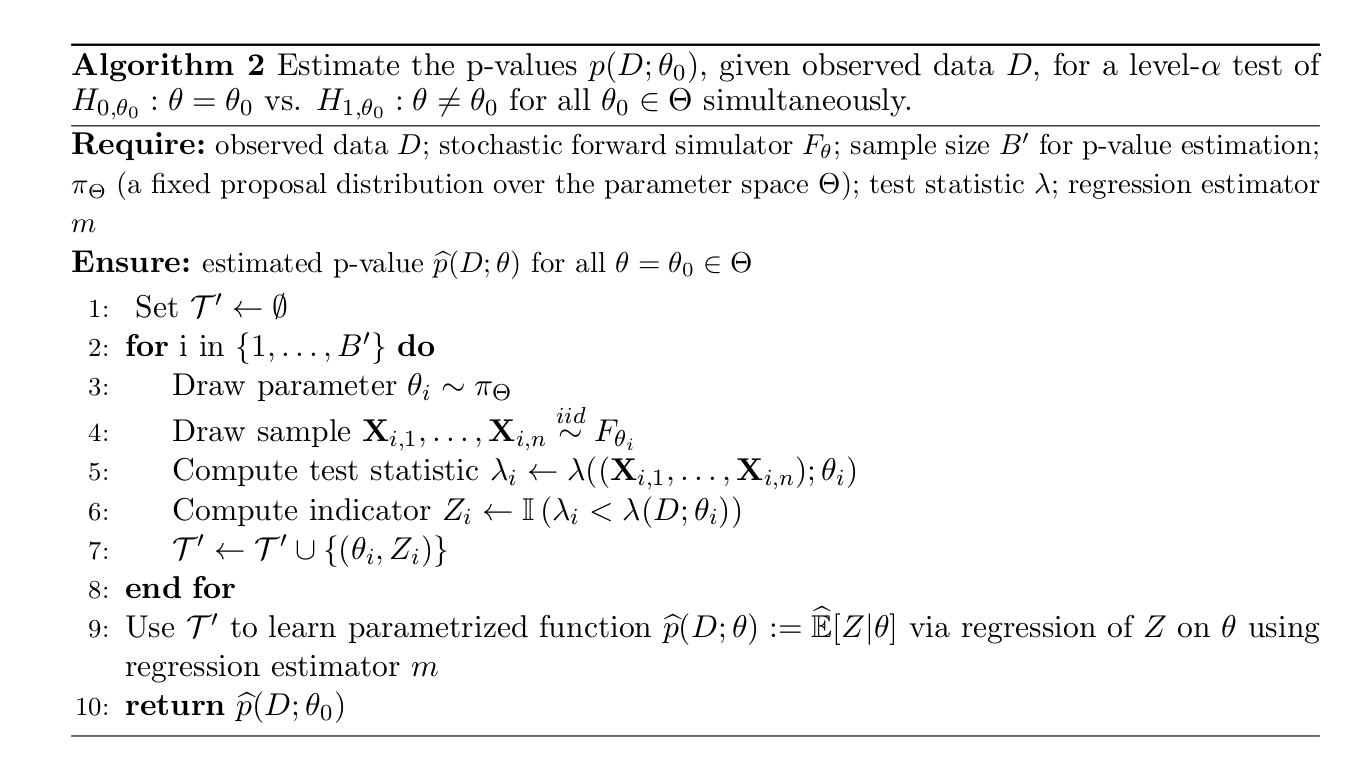

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
mp.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
# force inline plots
# %matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy
import pandas as pd
import sys
import os
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
def DR(s, theta):
    return sp.special.gammainc(s, theta)

def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)
from IPython.display import Image, display
algorithm2 = Image('src/images/Algorithm2.jpg')
display(algorithm2)

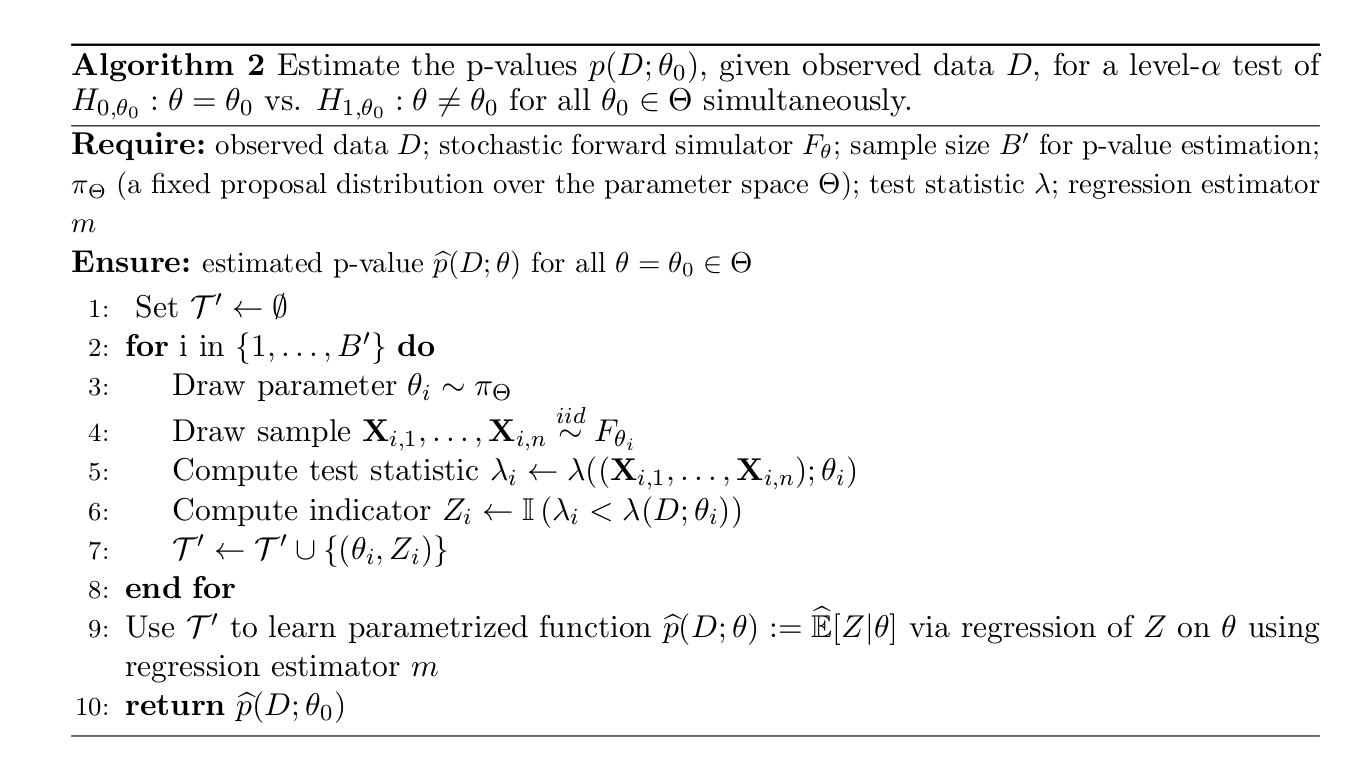

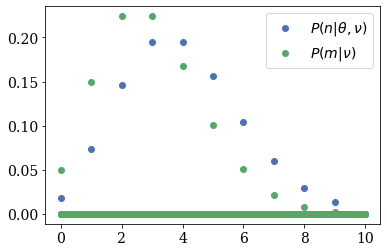

(1, 3)
(3, 2)
(3, 2)
(3, 2)
(1, 3)
(3, 0)


GenerateData_and_Train_2_parameters_step_1.ipynb:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  "M & \\sim \\textrm{uniform}(0, 10), \\textrm{ and } \\\\\n",


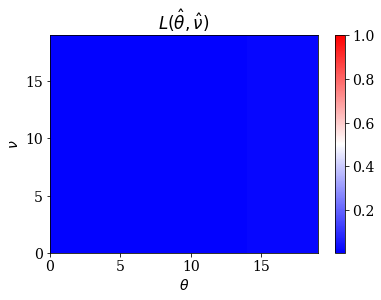

<Figure size 720x432 with 0 Axes>

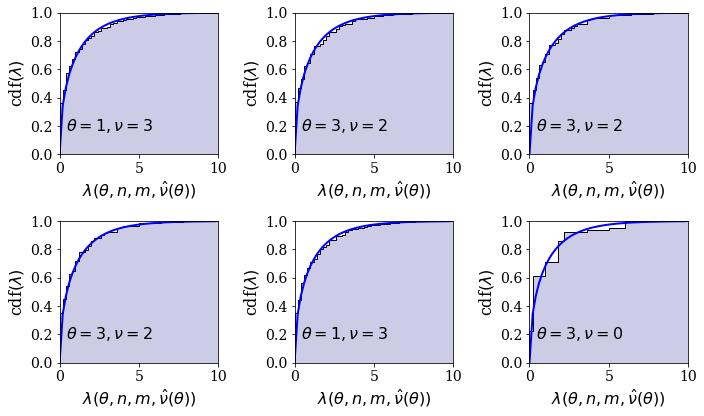

n= [31 67 50 ... 23 52 51]
m= [ 8 56 25 ... 18 25 15]
N= [16 19 27 ...  3  4  1]
M= [ 6 21  6 ... 22 20 13]
lambda_gen=  [0.03283729 0.13569589 0.13236405 ... 0.60958636 1.96269529 2.36319213]
lambda_D=  [ 7.06453329  6.83287019  1.41219322 ... 32.78211229 34.70155895
 56.89009429]
   Z      theta         nu   N   M
0  1  24.138277   7.476931  16   6
1  1  15.090572  39.034432  19  21
2  1  28.166701  29.162164  27   6
3  1  33.765543  31.100582  19  11
4  1  25.651882   9.140701  11  17


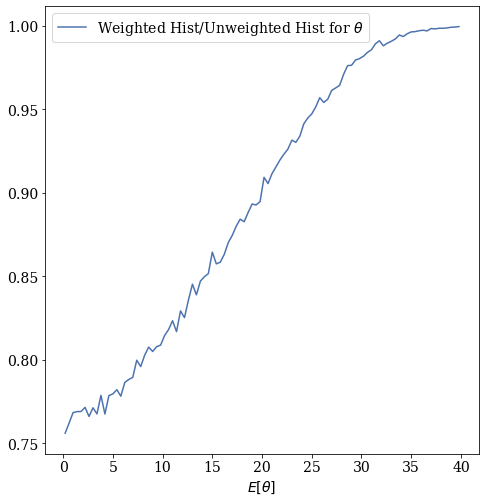

train set size:        980392
validation set size:     9804
test set size:           9804
Model(
  (layer0): Linear(in_features=4, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)
Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.292832	  0.291535
     19990	  0.044390	  0.045562
Iteration vs average loss
 iteration	 train-set	 valid-set
     29990	  0.044558	  0.045466


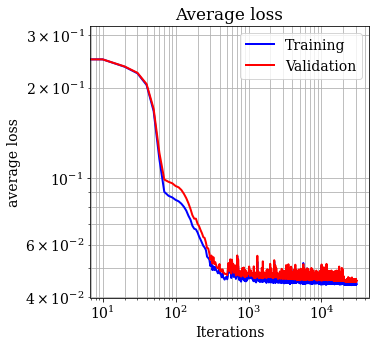

torch.Size([1000000])


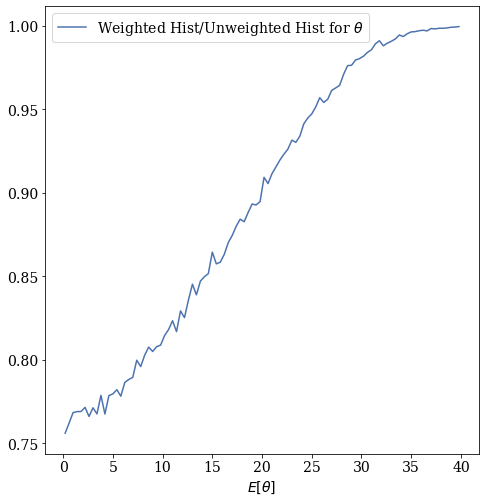

In [16]:
%run GenerateData_and_Train_2_parameters_step_1.ipynb

In [17]:
datafile = pd.read_csv('data/results/INFERENCE_DF_TWOPARAMS_1M.csv')
data=datafile[['Z', 'theta', 'nu', 'N', 'M', 'phat']]
data.head()

,Z,theta,nu,N,M,phat
0,1,24.138277,7.476931,16,6,0.995779
1,1,15.090572,39.034432,19,21,0.995376
2,1,28.166701,29.162164,27,6,0.764736
3,1,33.765543,31.100582,19,11,0.999999
4,1,25.651882,9.140701,11,17,1.000000


In [18]:
model = torch.load('models/Regressor_TwoParams_theta_nu_m_n.pth'); model.parameters

<bound method Module.parameters of Model(
  (layer0): Linear(in_features=4, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)>

### We use histogramming to compare with $\hat{p}(\theta,\nu,N,M)$

In [19]:
def hist_data_two_params(data, N, M, x):
    """Given a dataframe data which has columns theta and M and N, return a histogram of theta at those [M,N] values with the
    weights Z, divided by a histogram for theta at those D values without the weights. This will be the the approximate p value at bins x. The exact p value for D at x is calculated with DL"""
    # mask = (data['value2'] == 'some_string') & (data['value'] > 4)
    mask = (data.M == M) & (data.N == N)

    # weighted histogram   (count the number of ones per bin)
    y1, _ = np.histogram(data.theta[mask], 
                         bins=xbins, 
                         range=xrange, 
                         weights=data.Z[mask]) 

    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(data.theta[mask], 
                         bins=xbins, 
                         range=xrange)

    # approximation of DL(D, x)
    approx_p_by_hist =  y1 / yt    

    # exact
    # exact_p = DL(D, x)
    # inputs = ['theta', 'nu', 'N', 'M']
    # df_at_inputs = data[inputs]
    # df_at_inputs = df_at_inputs[mask]
    data_at_mask = data[mask]
    inputs = ['theta', 'nu', 'N', 'M']
    # data_df='data/two_parameters_N_M_Uniformly_sampled_1M.csv'
    # df = pd.read_csv(data_df)
    Input_features = data_at_mask[inputs]
    ############ ML inference part
    with torch.no_grad():
        model.eval()

        X = torch.Tensor(Input_features.values)
        phat = model(X)
        phat = phat.detach().flatten()
        # phat=phat.numpy()
        PHAT = phat.view(-1).numpy()
        print(phat.flatten().shape)

    # model_at_inputs =data.phat[mask]
    model_at_inputs = PHAT
    
    print('\napprox_p by histogramming =',approx_p_by_hist)
    print('\napprox_p by model =',model_at_inputs)
    return approx_p_by_hist, model_at_inputs 

In [20]:
xmin, xmax = 0, 20
xrange= (xmin, xmax)
xbins = 40
xstep = (xmax - xmin) / xbins
x     = np.arange(xmin+0.5*xstep, xmax + 0.5*xstep, xstep)
N, M = 12, 2
approx_p_by_hist, model_at_inputs = hist_data_two_params(data, N, M, x)

torch.Size([1117])

approx_p by histogramming = [1.         1.         0.92857143 0.91666667 0.92857143 1.
 0.875      1.         0.875      0.82352941 0.88235294 0.75
 0.75       0.53846154 0.72222222 0.58823529 0.7        0.38888889
 0.         0.         0.25       0.07692308 0.09090909 0.47058824
 0.28571429 0.54545455 0.64705882 0.625      0.64285714 0.83333333
 0.69230769 0.76923077 0.90909091 0.90909091 0.86666667 0.94117647
 0.94117647 0.92307692 0.91666667 1.        ]

approx_p by model = [0.9999999  0.2510692  0.99960834 ... 0.1981537  0.9988255  0.9999969 ]


In [21]:
approx_p_by_hist.shape, model_at_inputs.shape

((40,), (1117,))

ValueError: x and y must have same first dimension, but have shapes (40,) and (1117,)

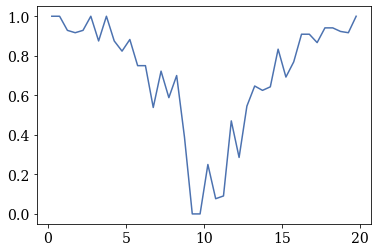

In [22]:
plt.plot(x, approx_p_by_hist, label='approx_p_by_hist')
plt.plot(x, model_at_inputs, label='approx_p_by_hist')
plt.legend()